# Train a random-forest classifier

Let's see how a random forest can learn to distinguish misogynistic
speech from generic speech.

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV

*Know more about Sci-kit learn: https://scikit-learn.org/stable/*

### Load the data

In [3]:
df = pd.read_csv("../data/gold_data_en.csv")

In [4]:
df.shape

(16265, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16265 entries, 0 to 16264
Data columns (total 2 columns):
text     16265 non-null object
label    16265 non-null int64
dtypes: int64(1), object(1)
memory usage: 254.2+ KB


### Balance classes

To avoid bias (i.e. when an algorithm prefers one class to the other) we need to have an equal number of elements for each class.

In [6]:
df.groupby('label').count()

,text
label,
0,9243
1,7022


One can see here that we have a different number of elements for the two
classes.
Let's change that.
First let's count the elements of the minority class.

In [7]:
n_elements = min(df.groupby('label').count().to_numpy())[0]
n_elements

7022

Then sample an equal number from the two classes.

In [8]:
df_positive = df[df['label']==1].sample(n_elements, random_state=42)
df_positive.head()

,text,label
8910,@initials_games Big news! Wait does kat actual...,1
6245,@DBTillman Skank,1
7880,"RT @Po0le_Boy: Call me sexist, but if you're w...",1
8762,RT @jeremymonti98 I'm not sexist but is this b...,1
8746,Managed to hit a bird and a small rodent on my...,1


In [9]:
df_negative = df[df['label']==0].sample(n_elements, random_state=42)
df_negative.head()

,text,label
4452,@talipann you won't retweet me pussy,0
12650,"""We know that you gave it everything you have,...",0
6304,@KTMSays @RichTD5 @stephenfry @EverydaySexism ...,0
3303,The next message you need is always right wher...,0
12875,@Pixelfish @ChrisWarcraft I shitposted in barr...,0


In [10]:
df_balanced = pd.concat((df_negative, df_positive)).reset_index(drop=True)
df_balanced

,text,label
0,@talipann you won't retweet me pussy,0
1,"""We know that you gave it everything you have,...",0
2,@KTMSays @RichTD5 @stephenfry @EverydaySexism ...,0
3,The next message you need is always right wher...,0
4,@Pixelfish @ChrisWarcraft I shitposted in barr...,0
5,This sentiment needs to be killed at the earli...,0
6,@CarlosD22428844 @Maureen6Johnson @NicolaSturg...,0
7,RT @PatriceChienne: Pony burgers from Annie wi...,0
8,@AlfieKent98 Grow up you slag,0
9,@Leonard_Delaney no more discrimination agains...,0


We store the balanced data in the original dataframe.

In [11]:
df = df_balanced

Now let's create the Spacy NLP documents from our text data.

First we need to load the language model.

In [12]:
nlp = spacy.load("en_core_web_md")

In [13]:
# The .pipe() method batch processes all the text (will take a little while)
docs = list(nlp.pipe(df['text']))

### Vectors visualization

Here we take the document vectors from Spacy.

In [14]:
vector_matrix = np.array(list(map(lambda x: x.vector, docs)))

In [15]:
vector_matrix.shape

(14044, 300)

We use PCA to project the vectors to their principal components.

In [16]:
pca = PCA(2)

In [17]:
x_pca = pca.fit_transform(vector_matrix)

In [18]:
x_pca.shape

(14044, 2)

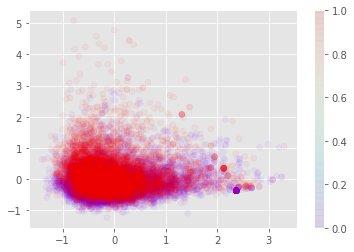

In [19]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['label'].tolist(), alpha=.05, cmap='rainbow');
plt.colorbar();

## Random forest classifier

The random forest algorithm is a pretty versatile one and generally
performs well.
Let's use the default parameters with just one change:
we'll use 100 trees.

In [20]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

### Train-test split

It's important to split the data consistently
so that we keep a 50/50 ratio both in training and test.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    vector_matrix,
    df['label'].to_numpy(),
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [22]:
x_train.shape

(11235, 300)

Let's check the class balance:

In [23]:
y_train.mean(), y_test.mean()

(0.5000445037828215, 0.49982200071199717)

And now we fit the model:

In [24]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Let's try the fitted model on the test set:

In [25]:
y_pred = rf.predict(x_test)

We can also extract probabilities.
The [1,0] prediction can always be recomputed
from the probabilities, knowing that the prediction is 1 when
the probability > 0.5 and 0 otherwise.

In [26]:
y_proba = rf.predict_proba(x_test)

There are several metrics to evaluate the performance of the model.
Common ones include the F1-score, the confusion matrix,
the ROC curve, and the area under the ROC curve (AUC).

In [27]:
f1_score(y_test, y_pred)

0.7284576393917451

Let's check what we get from the training data, just for fun:

In [28]:
f1_score(y_train, rf.predict(x_train))

0.9991100035599858

This is a very high value, which is expected since the training data has been used to train the model.

Let's look at what the prediction arrays look like.

In [29]:
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [30]:
y_proba

array([[0.64, 0.36],
       [0.8 , 0.2 ],
       [0.47, 0.53],
       ...,
       [0.59, 0.41],
       [0.48, 0.52],
       [0.51, 0.49]])

`y_proba` contains two columns, the first is the probability for class 0, the second is the probability
for class 1.

In [31]:
# This is a convenience function that takes care of boring stuff
def plot_roc_auc_f1(y_test, y_proba, title=None):
    f1 = f1_score(y_test, y_proba[:, 1]>.5)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc_score = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    if title is not None:
        ax.set_title(title)
    ax.plot([0, 1], [0, 1], '--', label="Random")
    ax.plot(fpr, tpr, label="Your model")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.annotate(f"AUC: {auc_score:.4}", (.8, 0.05))
    ax.annotate(f"F1: {f1:.4}", (.8, 0.0))
    ax.legend()
    return f1, auc_score

### ROC curve

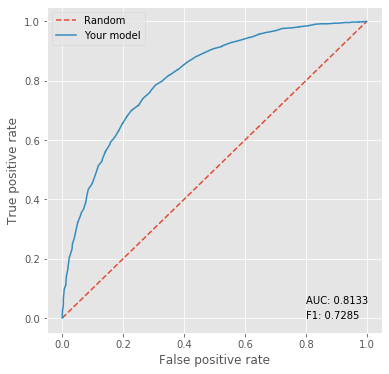

In [32]:
f1, auc_score = plot_roc_auc_f1(y_test, y_proba);

The straight line is equivalent to the performance of a random classifier.
The further away from it, the better.
The curve looks quite good and the given AUC is a decent value.

### F1-score, AUC

In [33]:
f1, auc_score

(0.7284576393917451, 0.8132628179781205)

The number of feature equals the length of the word vectors:

In [34]:
rf.n_features_

300

### A closer look at the predictions

In [35]:
df_train, df_test = train_test_split(
    df,
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [36]:
df_train.shape

(11235, 2)

In [37]:
df_test.shape

(2809, 2)

In [38]:
df_test['prediction'] = y_proba[:, 1]

/home/guzzo/anaconda3/envs/study-online-misogyny/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's take a look at what the model predicts.

In [39]:
df_test[df_test['prediction']>.5].sort_values('prediction', ascending=False)['text'].tolist()

['@Bourgholtzer feminazi',
 'Feminazi Blog Reminds Liberals Today Is “National Day of Appreciation for Abortion Providers”… http://t.co/hUIwlu7HCb via @WeaselZippers',
 '@MissTwilight12 feminazi',
 'Feminazi Blog Reminds Liberals Today Is “National Day of Appreciation for Abortion Providers”… http://t.co/JzmTLkVeyK',
 'Feminazi 😳',
 '... http://t.co/c6uBtx6TqE #asian #filipino #free #indian #japanese #oriental #thai #video #videos #vietnamese #whoriental #XXX',
 'whore https://t.co/aFLn8TY6sF',
 '... http://t.co/BI912bPbrG #asian #filipino #free #indian #japanese #oriental #thai #video #videos #vietnamese #whoriental #XXX',
 '@TylerIsAPerson whore',
 'I liked a @YouTube video from @uhohbrochannel http://t.co/Tpi0bCYLem Feminazi FAIL',
 'I liked a @YouTube video from @uhohbrochannel http://t.co/DKbZw5Qy3W Feminazi FAIL',
 '@mikeytheddking dumb fucking whore',
 '@blackhairedtiny fucking whore',
 'fucking bitch anSWER ME @thefembisexual https://t.co/XkoeqxKMZ0',
 'RT @THEBIRD_19: @MissTwi

In [40]:
df_test[df_test['prediction']<=.5].sort_values('prediction', ascending=False)['text'].tolist()

["@ArielaMigdal You know that's pure propaganda for dumb people right?",
 "Go ahead, sit on my purse strap and not get up when I say EXCUSE ME, it's not like I exist or take up space. #fuckmenonpublictransit",
 '@logie @PCairnsPhoto @ChrisGPackham @theSNP @NicolaSturgeon Change ur @ I’ll pay pal u 9.41 ty',
 "Erol is the world's leading light on #psychopaths, all psychopaths have a female brain &gt;&gt; https://t.co/L1lL5BkyLH &lt;&lt; #MGTOW #Feminazi #PTSD",
 'RT @dearsarah: @MadcapOcelot @freebsdgirl also (the awesome) @ellenchisa counted the # of women he follows &amp; wrote about it here http://t.c…',
 "@slainv_fr never said there wasn't. i just rarely see women using that term.",
 'RT @11thEarl: Priceless that #BringBackClarkson got more petitioners in a day than #feminazi - led #NoMorePage3 got in 3 years...oh the del…',
 "RT @theeaglesfan005: @Kbeelrsreiyen not my fault people feed stereotypes. For example my sister... She's been in multiple accidents",
 '#YesAllWomen should st

### Visualization of probability distribution

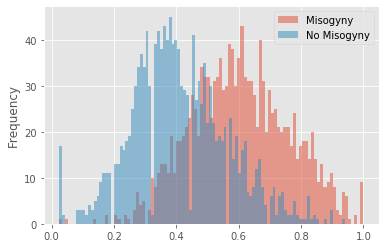

In [41]:
df_test['prediction'][df_test['label']==1].plot.hist(bins=99, alpha=.5, label="Misogyny")
df_test['prediction'][df_test['label']!=1].plot.hist(bins=99, alpha=.5, label="No Misogyny");
plt.legend();

## Parameter Optimization

One can fine-tune the model's hyperparameters in order to
find the best possible model.

In [42]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

In [43]:
# BEWARE: Searching for more than just a couple parameters will increase the calculation time exponentially!
param_grid = {
    "n_estimators": [50, 200],
#     "max_depth": [3, None],
#     "max_features": [1, 10, 100],
#     "min_samples_split": [10, 100, 1000],
#     "bootstrap": [True, False],
#     "criterion": ["gini", "entropy"],
}

In [44]:
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, iid=False, verbose=2, n_jobs=-1)

In [45]:
%%time
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.4s finished


CPU times: user 28.7 s, sys: 148 ms, total: 28.9 s
Wall time: 44.2 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=-1, param_grid={'n_estimators': [50

In [46]:
grid_search.cv_results_

{'mean_fit_time': array([ 5.66335382, 18.91877933]),
 'std_fit_time': array([0.27111775, 5.91357281]),
 'mean_score_time': array([0.15218129, 0.22090492]),
 'std_score_time': array([0.02808389, 0.06027611]),
 'param_n_estimators': masked_array(data=[50, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50}, {'n_estimators': 200}],
 'split0_test_score': array([0.73398577, 0.73176157]),
 'split1_test_score': array([0.71708185, 0.74243772]),
 'split2_test_score': array([0.73253227, 0.74454829]),
 'split3_test_score': array([0.72350846, 0.73775601]),
 'split4_test_score': array([0.72885129, 0.76090828]),
 'mean_test_score': array([0.72719193, 0.74348237]),
 'std_test_score': array([0.00621628, 0.00975765]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [47]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
f1_score(y_test, grid_search.predict(x_test))

0.7390988372093023

In [49]:
y_proba = grid_search.predict_proba(x_test)

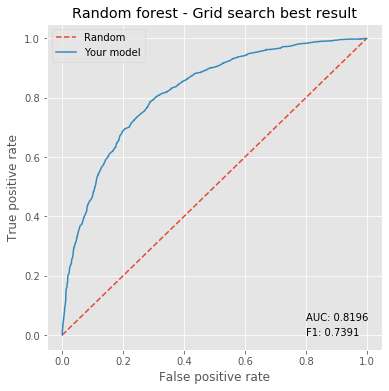

In [50]:
plot_roc_auc_f1(y_test, y_proba, title="Random forest - Grid search best result");

## Predict user input - A quick test

Remember: 0 is not misogynistic, 1 is misogynistic.

In [51]:
best_rf = grid_search.best_estimator_

In [52]:
misog_vector = nlp("Women are inferior to men.").vector

In [53]:
best_rf.predict(misog_vector.reshape(1, -1))

array([1])

In [54]:
best_rf.predict(nlp("Have a nice day").vector.reshape(1, -1))

array([0])

Seems to be working! :-)